In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

def compare_image_directories(source_dir, generated_dir):
    # Ensure the directories contain the same number of files
    source_images = sorted(os.listdir(source_dir))
    generated_images = sorted(os.listdir(generated_dir))
    if len(source_images) != len(generated_images):
        print("Warning: The directories do not contain the same number of images.")
        return

    # Full paths to the images
    source_image_paths = [os.path.join(source_dir, img) for img in source_images]
    generated_image_paths = [os.path.join(generated_dir, img) for img in generated_images]

    # Initialize the VGG16 model
    vgg16 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))
    # Freeze the layers
    for layer in vgg16.layers:
        layer.trainable = False

    # Define helper functions for loading and processing images
    def load_and_preprocess_image(img_path):
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        return preprocess_input(img_array_expanded)

    def get_image_embeddings(img_array):
        return vgg16.predict(img_array)

    def get_similarity_score(first_img_path, second_img_path):
        first_img_array = load_and_preprocess_image(first_img_path)
        second_img_array = load_and_preprocess_image(second_img_path)
        first_img_embedding = get_image_embeddings(first_img_array)
        second_img_embedding = get_image_embeddings(second_img_array)
        return cosine_similarity(first_img_embedding, second_img_embedding)[0][0]

    # Calculate similarity scores
    similarity_scores = []
    for source_path, generated_path in zip(source_image_paths, generated_image_paths):
        score = get_similarity_score(source_path, generated_path)
        similarity_scores.append(score)

    # Optional: Print some statistics
    min_score = min(similarity_scores)
    max_score = max(similarity_scores)
    mean_score = sum(similarity_scores) / len(similarity_scores)
    print(f"Minimum similarity score: {min_score}")
    print(f"Maximum similarity score: {max_score}")
    print(f"Mean similarity score: {mean_score}")

    return similarity_scores

In [52]:
sim_clip = compare_image_directories('images_dataset_resized_1024', 'images_output_clip_100_200_old_model')
sim_gpt4_color = compare_image_directories('outputt\\.r\\orig', 'outputt\\.r\\gen')
sim_gpt4_color2 = compare_image_directories('images_dataset_resized_1024', 'images_output_fused')
sim_gpt4_only_prompt = compare_image_directories('images_dataset_resized_1024', 'images_output_gpt4_only_prompts')
sim_gpt4 = compare_image_directories('images_dataset_resized_1024-wo-12', 'images_output_gpt4_100_200_new_model')


1/1 [==============================] - 0s 59ms/step
Minimum similarity score: 0.06611135601997375
Maximum similarity score: 0.905457079410553
Mean similarity score: 0.7454999125003815
1/1 [==============================] - 0s 68ms/step
Minimum similarity score: 0.5067117810249329
Maximum similarity score: 0.9495389461517334
Mean similarity score: 0.8613075665632883
1/1 [==============================] - 0s 57ms/step
Minimum similarity score: 0.15291476249694824
Maximum similarity score: 0.9239100813865662
Mean similarity score: 0.8322736742099126
1/1 [==============================] - 0s 63ms/step
Minimum similarity score: 0.09972655773162842
Maximum similarity score: 0.8086658716201782
Mean similarity score: 0.6245187463363012
1/1 [==============================] - 0s 56ms/step
Minimum similarity score: 0.3209459185600281
Maximum similarity score: 0.9044774770736694
Mean similarity score: 0.7528874806109691


In [53]:
# save all similarity scores
np.save('sim_clip.npy', sim_clip)
np.save('sim_gpt4_color.npy', sim_gpt4_color)
np.save('sim_gpt4_color2.npy', sim_gpt4_color2)
np.save('sim_gpt4_only_prompt.npy', sim_gpt4_only_prompt)
np.save('sim_gpt4.npy', sim_gpt4)

In [68]:
def sim_metrics(ss, name="Results"):
     # Optional: Print some statistics
    min_score = min(ss)
    max_score = max(ss)
    mean_score = sum(ss) / len(ss)
    median_score = np.median(ss)
    print("---", name, "---")
    print(f"• Minimum similarity score:\t {min_score}")
    print(f"• Maximum similarity score:\t {max_score}")
    print(f"• Mean similarity score:\t {mean_score}")
    print(f"• Median similarity score:\t {median_score}")
    print()



sim_metrics(sim_clip, "CLIP (Canny)")
sim_metrics(sim_gpt4, "GPT4")
sim_metrics(sim_gpt4_color, "GPT4 Color (Sketches)")
sim_metrics(sim_gpt4_color2, "GPT4 Color (Canny)")
sim_metrics(sim_gpt4_only_prompt, "GPT4 Only Prompt")

--- CLIP (Canny) ---
• Minimum similarity score:	 0.06611135601997375
• Maximum similarity score:	 0.905457079410553
• Mean similarity score:	 0.7454999125003815
• Median similarity score:	 0.7616867423057556

--- GPT4 ---
• Minimum similarity score:	 0.3209459185600281
• Maximum similarity score:	 0.9044774770736694
• Mean similarity score:	 0.7528874806109691
• Median similarity score:	 0.7632178068161011

--- GPT4 Color (Sketches) ---
• Minimum similarity score:	 0.5067117810249329
• Maximum similarity score:	 0.9495389461517334
• Mean similarity score:	 0.8613075665632883
• Median similarity score:	 0.8757397532463074

--- GPT4 Color (Canny) ---
• Minimum similarity score:	 0.15291476249694824
• Maximum similarity score:	 0.9239100813865662
• Mean similarity score:	 0.8322736742099126
• Median similarity score:	 0.8558453917503357

--- GPT4 Only Prompt ---
• Minimum similarity score:	 0.09972655773162842
• Maximum similarity score:	 0.8086658716201782
• Mean similarity score:	 0.62

In [57]:
import json

file_path1 = 'edge-content-reconstruction/compression/bws_clip.json'
file_path2 = 'edge-content-reconstruction/compression/bws_gpt4.json'
file_path3 = 'edge-content-reconstruction/compression/bws_gpt4_color.json'
file_path4 = 'edge-content-reconstruction/compression/bws_gpt4_color2.json'

with open(file_path1, 'r') as file:
    data = json.load(file)
    bws_clip = [
        (entry['original image size'] - entry['post compression size with prompt']) / entry['original image size'] * 100        
        for entry in data
    ]

with open(file_path2, 'r') as file:
    data = json.load(file)
    bws_gpt4 = [
        (entry['original image size'] - entry['post compression size with prompt']) / entry['original image size'] * 100        
        for entry in data
    ]

with open(file_path3, 'r') as file:
    data = json.load(file)
    bws_gpt4_color = [
        (entry['original image size'] - entry['post compression size with prompt']) / entry['original image size'] * 100        
        for entry in data
    ]

with open(file_path4, 'r') as file:
    data = json.load(file)
    bws_gpt4_color2 = [
        (entry['original image size'] - entry['post compression size with prompt']) / entry['original image size'] * 100        
        for entry in data
    ]

with open(file_path2, 'r') as file:
    data = json.load(file)
    bws_gpt4_only_prompt = [
        (entry['original image size'] - entry['prompt size']) / entry['original image size'] * 100        
        for entry in data
    ]

In [70]:
sim_metrics(bws_clip, "CLIP (Canny)")
sim_metrics(bws_gpt4[:11] + bws_gpt4[12:], "GPT4")
sim_metrics(bws_gpt4_color, "GPT4 Color (Sketches)")
sim_metrics(bws_gpt4_color2, "GPT4 Color (Canny)")
sim_metrics(bws_gpt4_only_prompt, "GPT4 Only Prompt")

np.save('bws_clip.npy', bws_clip)
np.save('bws_gpt4.npy', bws_gpt4[:11] + bws_gpt4[12:])
np.save('bws_gpt4_color.npy', bws_gpt4_color)
np.save('bws_gpt4_color2.npy', bws_gpt4_color2)
np.save('bws_gpt4_only_prompt.npy', bws_gpt4_only_prompt)

--- CLIP (Canny) ---
• Minimum similarity score:	 73.86097446708831
• Maximum similarity score:	 99.93996783141093
• Mean similarity score:	 92.77196250506937
• Median similarity score:	 92.86573496674706

--- GPT4 ---
• Minimum similarity score:	 73.98834621691263
• Maximum similarity score:	 99.94068893854113
• Mean similarity score:	 92.7850207099408
• Median similarity score:	 92.85011094790137

--- GPT4 Color (Sketches) ---
• Minimum similarity score:	 -262.6984126984127
• Maximum similarity score:	 97.11474704754394
• Mean similarity score:	 73.37342343014107
• Median similarity score:	 86.03762023463848

--- GPT4 Color (Canny) ---
• Minimum similarity score:	 73.98834621691263
• Maximum similarity score:	 99.94068893854113
• Mean similarity score:	 92.7951948752801
• Median similarity score:	 92.93890456659634

--- GPT4 Only Prompt ---
• Minimum similarity score:	 97.79514373430086
• Maximum similarity score:	 99.99860819452412
• Mean similarity score:	 99.82404576979194
• Media

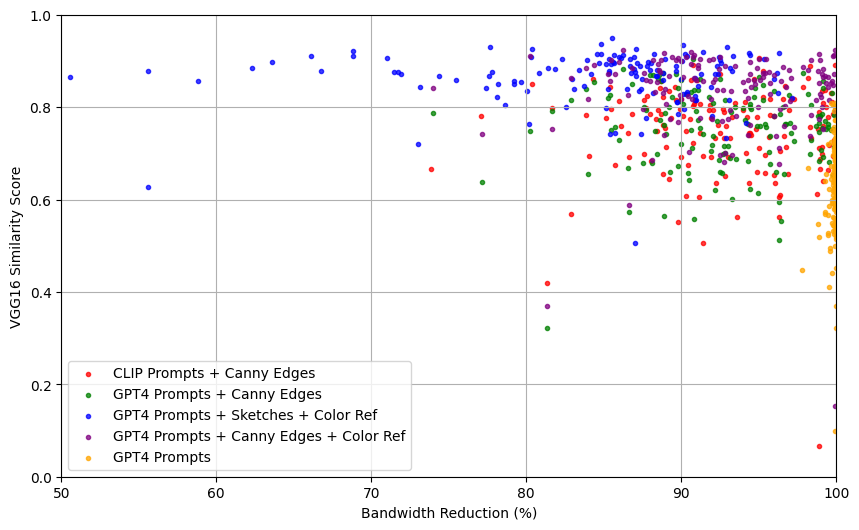

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

plt.scatter(bws_clip, sim_clip, alpha=0.75, marker='.', color='red', label='CLIP Prompts + Canny Edges')
plt.scatter(bws_gpt4[:11] + bws_gpt4[12:], sim_gpt4, alpha=0.75, marker='.', color='green', label='GPT4 Prompts + Canny Edges')
plt.scatter(bws_gpt4_color, sim_gpt4_color, alpha=0.75, marker='.', color='blue', label='GPT4 Prompts + Sketches + Color Ref')
plt.scatter(bws_gpt4_color2, sim_gpt4_color2, alpha=0.75, marker='.', color='purple', label='GPT4 Prompts + Canny Edges + Color Ref')
plt.scatter(bws_gpt4_only_prompt, sim_gpt4_only_prompt, alpha=0.75, marker='.', color='orange', label='GPT4 Prompts')

plt.xlabel('Bandwidth Reduction (%)')
plt.ylabel('VGG16 Similarity Score')
plt.xlim(50, 100)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.legend(loc='lower left')
plt.show()


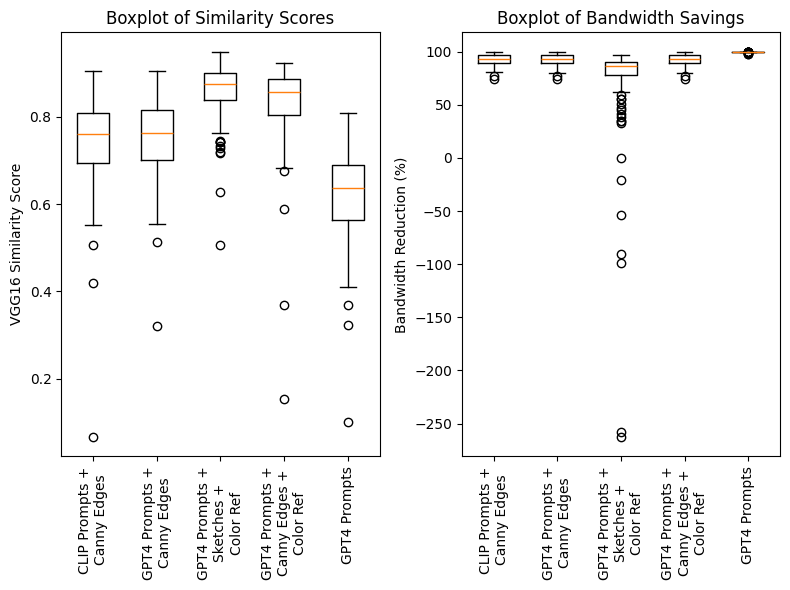

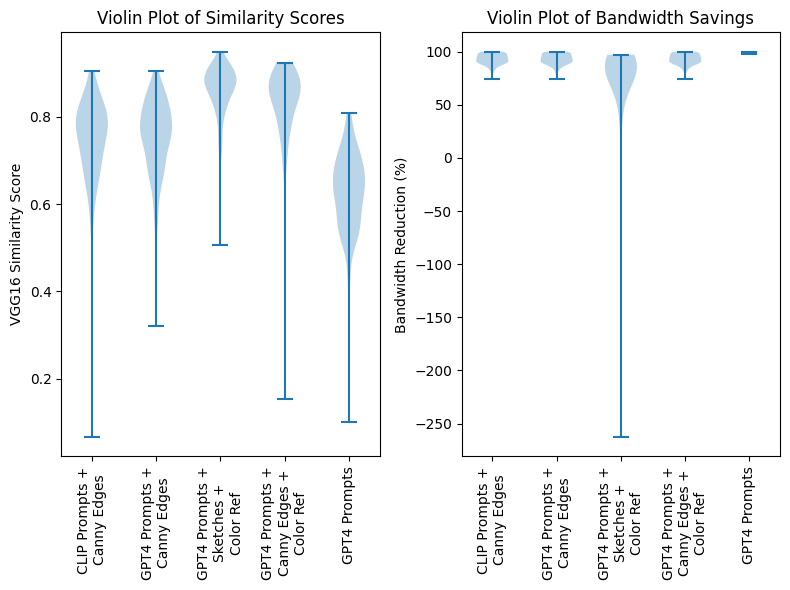

In [64]:
# Combine the data for boxplots and violin plots
all_bandwidth_savings = [bws_clip, bws_gpt4[:11] + bws_gpt4[12:], bws_gpt4_color, bws_gpt4_color2, bws_gpt4_only_prompt]
all_similarity_scores = [sim_clip, sim_gpt4, sim_gpt4_color, sim_gpt4_color2, sim_gpt4_only_prompt]
labels = ['CLIP Prompts +\nCanny Edges', 'GPT4 Prompts +\nCanny Edges', 'GPT4 Prompts +\nSketches +\nColor Ref', 'GPT4 Prompts +\nCanny Edges +\nColor Ref', 'GPT4 Prompts']

# Creating boxplots
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.boxplot(all_similarity_scores, labels=labels)
plt.title('Boxplot of Similarity Scores')
plt.ylabel('VGG16 Similarity Score')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.boxplot(all_bandwidth_savings, labels=labels)
plt.title('Boxplot of Bandwidth Savings')
plt.ylabel('Bandwidth Reduction (%)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Creating violin plots
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.violinplot(all_similarity_scores)
plt.xticks(np.arange(1, len(labels)+1), labels)
plt.title('Violin Plot of Similarity Scores')
plt.ylabel('VGG16 Similarity Score')
plt.xticks(rotation=90)
# rotated labels


plt.subplot(1, 2, 2)
plt.violinplot(all_bandwidth_savings)
plt.xticks(np.arange(1, len(labels)+1), labels)
plt.title('Violin Plot of Bandwidth Savings')
plt.ylabel('Bandwidth Reduction (%)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

C:\Users\Danish\AppData\Local\Temp\ipykernel_45444\1909871001.py:6: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sim_clip, cmap="Reds", shade=True, shade_lowest=False, label='CLIP Prompts')
C:\Users\Danish\AppData\Local\Temp\ipykernel_45444\1909871001.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sim_clip, cmap="Reds", shade=True, shade_lowest=False, label='CLIP Prompts')
C:\Users\Danish\AppData\Local\Temp\ipykernel_45444\1909871001.py:7: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sim_gpt4, cmap="Greens", shade=True, shade_lowest=False, label='GPT4 Prompts')
C:\Users\Danish\AppData\Local\Temp\ipykernel_45444\1909

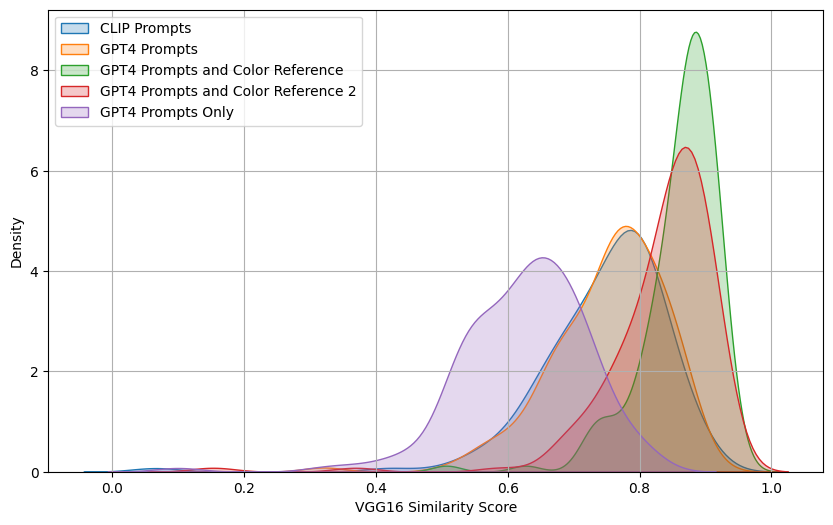

In [67]:
# Plot Distribution Curves

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(sim_clip, cmap="Reds", shade=True, shade_lowest=False, label='CLIP Prompts')
sns.kdeplot(sim_gpt4, cmap="Greens", shade=True, shade_lowest=False, label='GPT4 Prompts')
sns.kdeplot(sim_gpt4_color, cmap="Blues", shade=True, shade_lowest=False, label='GPT4 Prompts and Color Reference')
sns.kdeplot(sim_gpt4_color2, cmap="Blues", shade=True, shade_lowest=False, label='GPT4 Prompts and Color Reference 2')
sns.kdeplot(sim_gpt4_only_prompt, cmap="Oranges", shade=True, shade_lowest=False, label='GPT4 Prompts Only')

# plt.xlabel('Bandwidth Reduction (%)')
plt.xlabel('VGG16 Similarity Score')
plt.grid(True)
plt.legend()
plt.legend(loc='upper left')
plt.show()